In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re
import pprint

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from collections import defaultdict
from collections import Counter, ChainMap

from wordcloud import WordCloud

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import pyLDAvis.sklearn

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

with open('../data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('../data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

# Dataset preprocessing:

## Keep cases of Unknown Homeland (Ukendt hjemland):

In [3]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

(192, 1)

In [4]:

df.head()

text
201           Nævnet stadfæstede i november 2021 Udl...
428           Nævnet stadfæstede i juni 2021 Udlændi...
464           Nævnet stadfæstede i juni 2021 Udlændi...
901           Nævnet stadfæstede i december 2020 Udl...
1291          Nævnet hjemviste i juni 2020 Udlænding...

Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

text
1333          Nævnet stadfæstede i maj 2020 Udlændin...
1352          Nævnet stadfæstede i maj 2020 Udlændin...
4000          Nævnet stadfæstede i januar 2018 Udlæn...
4001          Nævnet stadfæstede i januar 2018 Udlæn...
4055          Nævnet stadfæstede i januar 2018 Udlæn...
4058          Nævnet stadfæstede i januar 2018 Udlæn...

In [6]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

# Create a pipeline:

Below are the steps taken to process the texts.

In [11]:
# Load danish model from spacy:
nlp = spacy.load("da_core_news_md")

STOPWORDS_DANISH = set(stopwords.words('danish'))

# domain specific words included:
domain_stopwords = {'nævnet', 'nævnets', 'nævnt', '​nævnet', 'flygtningenævnet', 'januar', 'februar', 'marts', 'april',
'maj', 'juni', 'juli', 'august', 'september', 'oktober', 'november', 'december', 'jf', 'ansøger'}

def import_additional_danish_stopwords(STOPWORDS_DANISH):
    additional_stopwords = open('../misc/stopwords_dk.txt', 'r')
    for line in additional_stopwords:
        words = line.strip()
        STOPWORDS_DANISH.add(words)
    return STOPWORDS_DANISH


STOPWORDS_DANISH = import_additional_danish_stopwords(STOPWORDS_DANISH)
STOPWORDS_DANISH |= domain_stopwords 

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'

In [12]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(text):
    """custom function to remove stopwords"""
    return [word for word in str(text).split() if word not in STOPWORDS_DANISH] 
    

# def tokenize(text):
#     """the following expression matches tokens consisting of at least one letter (\p{L}), 
#     preceded and followed by an arbitrary sequence of alphanumeric characters 
#     (\w includes digits, letters, and underscore) and hyphens (-)"""
#     return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def tokenize(text):
    doc = nlp.tokenizer(' '.join(text))
    return [token.text for token in doc]

def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc]


Steps can be added or removed from the pipeline.

In [13]:
pipeline = [str.lower, remove_punctuation, remove_stopwords, drop_single_letter_words,
            tokenize, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [14]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [15]:
df.head()

text  \
201           Nævnet stadfæstede i november 2021 Udl...   
428           Nævnet stadfæstede i juni 2021 Udlændi...   
464           Nævnet stadfæstede i juni 2021 Udlændi...   
901           Nævnet stadfæstede i december 2020 Udl...   
1291          Nævnet hjemviste i juni 2020 Udlænding...   

                                                 tokens  num_tokens  
201   [stadfæste, 2021, udlændingestyrels, afgørelse...         333  
428   [stadfæste, 2021, udlændingestyrels, afgørelse...         225  
464   [stadfæste, 2021, udlændingestyrels, afgørelse...         324  
901   [stadfæste, 2020, udlændingestyrels, afgørelse...         187  
1291  [hjemvise, 2020, udlændingestyrels, afgørelse,...         330

# Analysis:

In [16]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

## Topic Modelling:

### Latent Dirichlet Allocation (LDA):


Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

For a given corpus, a topic model estimates a topic distribution for each of its documents (i.e., a a distribution of weights over a set of topics), where a topic is itself a distribution of weights over the vocabulary of the corpus. The most weighted words of each topic are syntactically and/or semantically related, given that collection of documents. This means that two distinct topics share the exact same vocabulary, but have different weight distributions.

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

REFs here [1](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) and [2](https://arxiv.org/pdf/1405.0099.pdf).

In [17]:
# Utility function to display topics produced by Topic Modelling
def display_topics(model, features, num_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # inverts sort order
        print("\nTopic %02d" % topic)
        for i in range(0, num_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

In [18]:
count_text_vectorizer = CountVectorizer( min_df=2, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_joined'])

### Coherence Score:

Compute the coherence score is essentially a measure of how similar the words assigned to each topic are in terms of semantic value. The higher the score, the better.

Compute the coherence score for LDA models with 2 to 10 topics and see which number of topics leads to the highest coherence score.

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [19]:
best_num_LDA = float('NaN')
best_score_LDA = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create LDA model with i topics
    LDA_text_model = LatentDirichletAllocation(n_components=i, random_state=42)
    W_LDA_text_matrix = LDA_text_model.fit_transform(count_text_vectors)
    H_LDA_text_matrix = LDA_text_model.components_

    # Obtain the coherence score
    coherence_model_LDA = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_LDA_text_matrix, 
                        dtm=W_LDA_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_LDA = np.around(coherence_model_LDA, 2)
    for score in coherence_score_LDA:
        if score > best_score_LDA:
            best_num_LDA = i
            best_score_LDA = score

print(f'The coherence score for LDA ({best_score_LDA}) is highest with {best_num_LDA} topics.')

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


The coherence score for LDA (0.76) is highest with 3 topics.


Build the model with the best number of topics and see them:

In [20]:
LDA_model = LatentDirichletAllocation(n_components=best_num_LDA, random_state=42)
W_LDA_model_matrix = LDA_model.fit_transform(count_text_vectors)
H_LDA_model_matrix = LDA_model.components_

In [21]:
display_topics(LDA_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 kvindelig (1.53)
 mor (1.25)
 demonstration (1.13)
 hjemland (1.10)
 år (1.08)

Topic 01
 demonstration (1.73)
 bidoon (1.27)
 deltage (1.15)
 dag (0.97)
 bopæl (0.86)

Topic 02
 eritrea (1.78)
 divergere (0.91)
 sudan (0.81)
 sandsynliggøre (0.80)
 år (0.79)


Visualise the topics produced by LDA:

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

LDA_display = pyLDAvis.sklearn.prepare(LDA_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(LDA_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.

### NMF:

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Non-Negative Matrix Factorization is a statistical method that helps us to reduce the dimension of the input corpora or corpora. Internally, it uses the factor analysis method to give comparatively less weightage to the words that are having less coherence

REFs here [1](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), [2](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45)

In [23]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_NMF = float('NaN')
best_score_NMF = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create NMF model with i topics
    NMF_text_model = NMF(n_components=i, random_state=42, max_iter=2000)
    W_NMF_text_matrix = NMF_text_model.fit_transform(count_text_vectors)
    H_NMF_text_matrix = NMF_text_model.components_

    # Obtain the coherence score
    coherence_model_NMF = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_NMF_text_matrix, 
                        dtm=W_NMF_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_NMF = np.around(coherence_model_NMF, 2)
    for score in coherence_score_NMF:
        if score > best_score_NMF:
            best_num_NMF = i
            best_score_NMF = score

print(f'The coherence score for NMF ({best_score_NMF}) is highest with {best_num_NMF} topics.')

The coherence score for NMF (0.73) is highest with 10 topics.


Build the model with the best number of topics and see them:

In [24]:
NMF_model = NMF(n_components=best_num_NMF, random_state=42, max_iter=2000)
W_NMF_model_matrix = NMF_model.fit_transform(count_text_vectors)
H_NMF_model_matrix = NMF_model.components_

In [25]:
display_topics(NMF_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (6.84)
 deltage (4.46)
 2014 (2.21)
 bidoon (2.02)
 dag (1.67)

Topic 01
 klager (11.17)
 opholdstilladelse (2.43)
 klagere (1.32)
 pas (1.23)
 syrisk (1.18)

Topic 02
 dag (3.03)
 bopæl (2.97)
 gang (2.64)
 tage (2.01)
 hjem (1.75)

Topic 03
 ægtefælle (8.22)
 ansøgere (2.81)
 barn (2.43)
 bidoon (1.59)
 ægtefæll (1.58)

Topic 04
 kvindelig (2.63)
 videre (1.84)
 demonstration (1.77)
 oplysnings (1.69)
 angiveligt (1.53)

Topic 05
 bidoon (1.75)
 navn (1.60)
 mor (1.56)
 ansøgere (1.34)
 føde (1.20)

Topic 06
 barn (2.28)
 oplysning (1.68)
 bidooner (1.59)
 demonstration (1.58)
 sag (1.31)

Topic 07
 kvindelig (4.75)
 dag (1.57)
 asylsamtale (1.33)
 ansøg (1.30)
 bidooner (1.17)

Topic 08
 bror (3.68)
 divergere (2.43)
 opholdstilladelse (1.25)
 bopæl (1.20)
 dokument (1.08)

Topic 09
 eritrea (6.49)
 sudan (3.15)
 år (2.32)
 eritreisk (1.74)
 etiopien (1.52)


Visualise the topics produced by NMF:

In [26]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


NMF_display = pyLDAvis.sklearn.prepare(NMF_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(NMF_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentat

### Latent Semantic Analysis/Indexing:

Similar analysis to NMF but using a different algorithm: Singular Value Decomposition (SVD).

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

With the rank reduction of the original matrix, what we have is an approximation of the document-term matrix, with a new representation of each document in our corpus. The idea behind LSA is that the original corpus consists of a multitude of terms that in essence have the same meaning. The original matrix can in this sense be viewed as an obscured version of the underlying latent structure we discover when the redundant dimensions are forced together.

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

REFs here [1](https://simonpaarlberg.com)

In [27]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_SVD = float('NaN')
best_score_SVD = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create SVD model with i topics
    SVD_text_model = TruncatedSVD(n_components=i, random_state=42)
    W_SVD_text_matrix = SVD_text_model.fit_transform(count_text_vectors)
    H_SVD_text_matrix = SVD_text_model.components_

    # Obtain the coherence score
    coherence_model_SVD = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_SVD_text_matrix, 
                        dtm=W_SVD_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_SVD = np.around(coherence_model_SVD, 2)
    for score in coherence_score_SVD:
        if score > best_score_SVD:
            best_num_SVD = i
            best_score_SVD = score

print(f'The coherence score for SVD ({best_score_SVD}) is highest with {best_num_SVD} topics.')

The coherence score for SVD (0.76) is highest with 10 topics.


Build the model with the best number of topics and see them:

In [28]:
SVD_model = TruncatedSVD(n_components=best_num_SVD, random_state=42)
W_SVD_model_matrix = SVD_model.fit_transform(count_text_vectors)
H_SVD_model_matrix = SVD_model.components_

In [29]:
display_topics(SVD_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (1.72)
 kvindelig (1.07)
 deltage (1.04)
 bidoon (1.03)
 bopæl (0.99)

Topic 01
 klager (55.92)
 opholdstilladelse (10.84)
 klagere (6.64)
 syrisk (6.00)
 pas (5.84)

Topic 02
 bopæl (6.40)
 gang (5.77)
 dag (5.44)
 kvindelig (5.17)
 mor (5.04)

Topic 03
 ansøgere (7.07)
 ægtefælle (2.96)
 følge (2.81)
 barn (2.50)
 oplysning (2.29)

Topic 04
 dag (-11.24)
 deltage (-5.00)
 gang (-4.29)
 ægtefæll (-4.09)
 demonstration (-4.03)

Topic 05
 barn (-12.10)
 ægtefælle (-9.08)
 kvindelig (-6.21)
 ægtefæll (-6.05)
 bopæl (-5.46)

Topic 06
 eritrea (29.37)
 2014 (16.97)
 demonstration (15.79)
 sudan (14.60)
 gang (13.94)

Topic 07
 kvindelig (11.15)
 eritrea (7.37)
 barn (4.37)
 bemærke (4.00)
 bidooner (3.98)

Topic 08
 bror (7.75)
 bopæl (7.20)
 bemærke (6.72)
 oplysning (6.28)
 opsøgt (6.08)

Topic 09
 syrisk (14.89)
 mor (14.16)
 sommer (13.42)
 syrien (12.93)
 nærmere (11.40)


## Visualizations:

### Wordclouds:

In [31]:
# Utility function to produce wordclouds from topic modelling algorithms
def wordcloud_topics (model, features, no_top_words=40):
    for topics, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # inverts order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')

WordClouds from the LDA model:

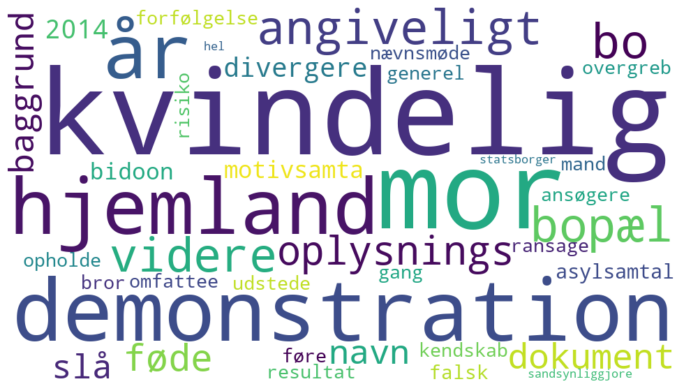

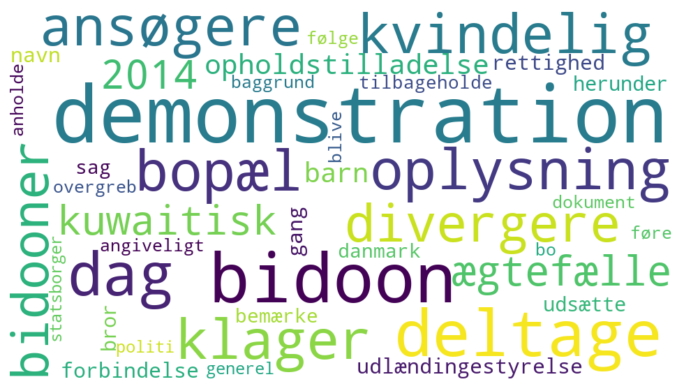

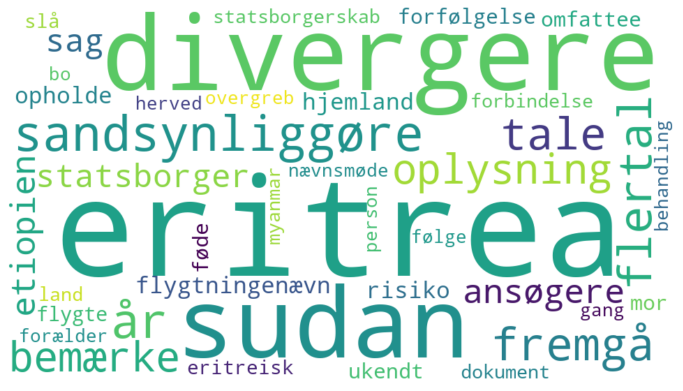

In [32]:
wordcloud_topics(LDA_model, count_text_vectorizer.get_feature_names_out())

WordClouds from the NMF model:

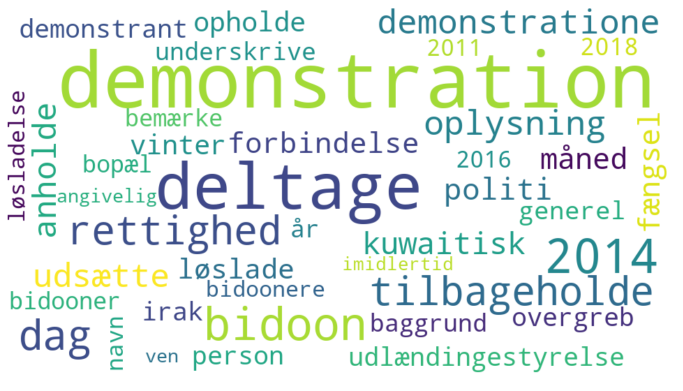

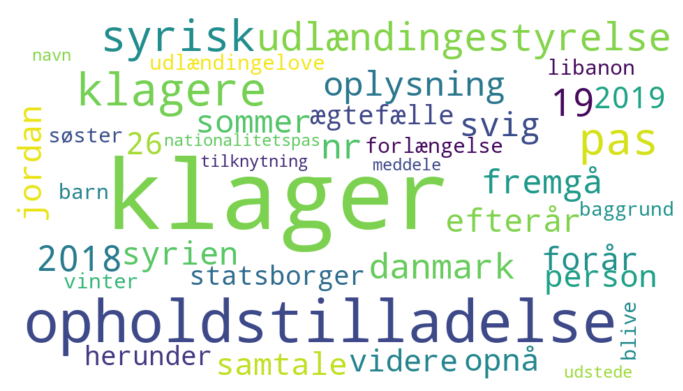

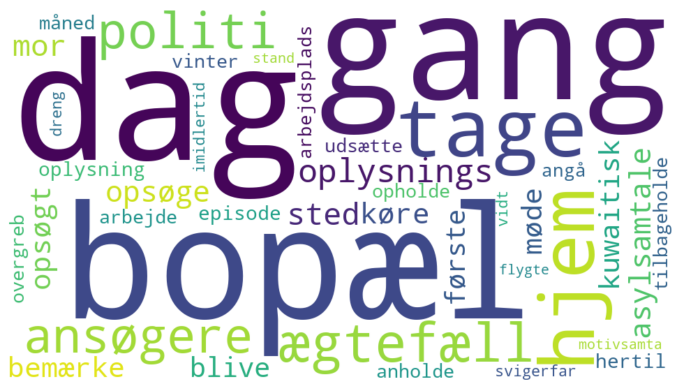

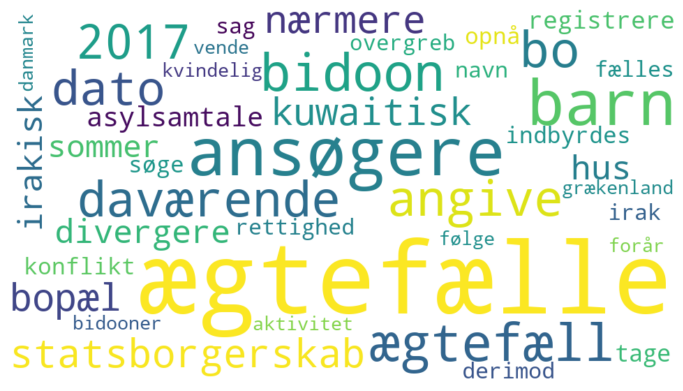

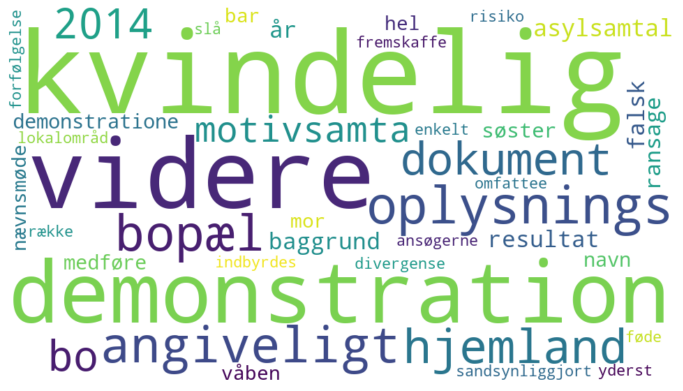

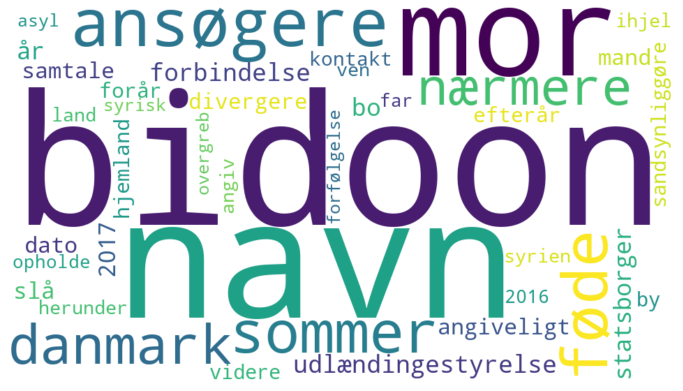

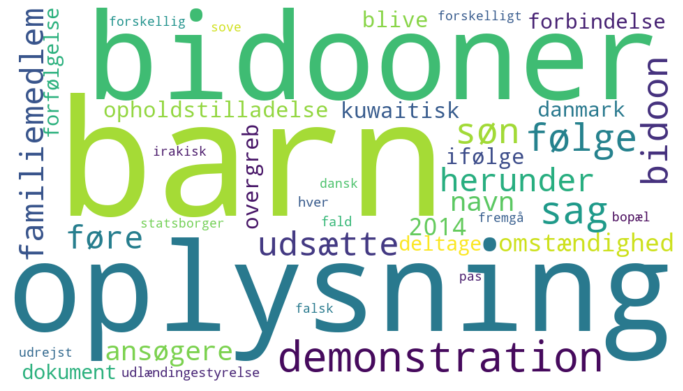

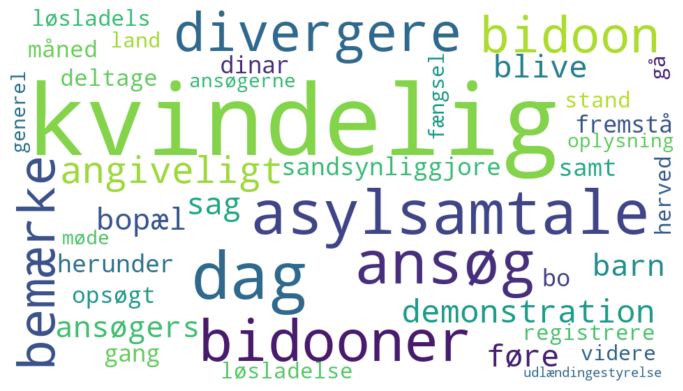

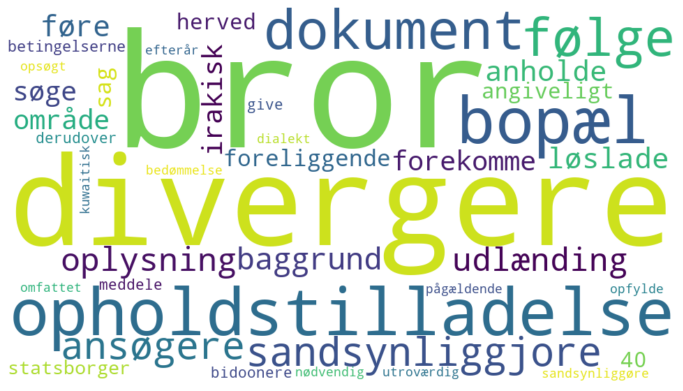

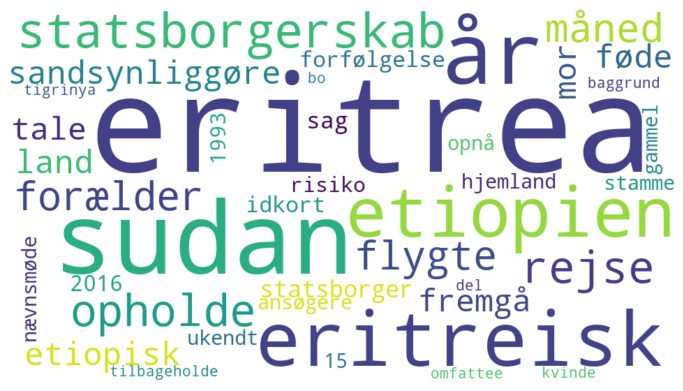

In [33]:
wordcloud_topics(NMF_model, count_text_vectorizer.get_feature_names_out())

WordsClouds from the SVD model:

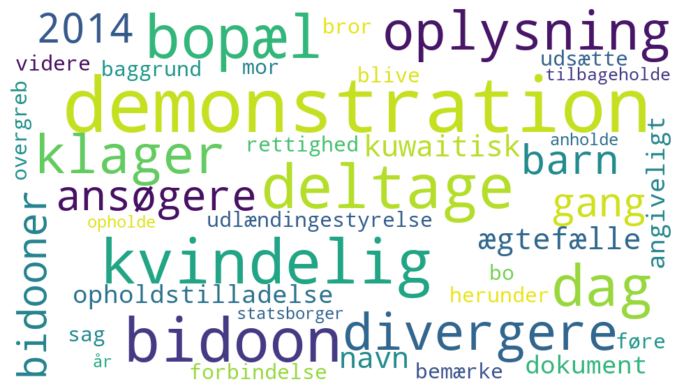

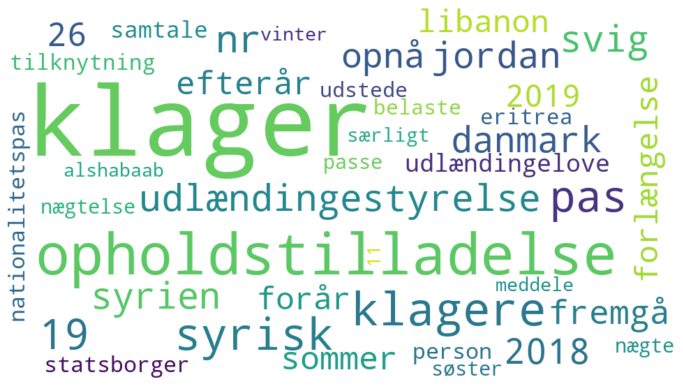

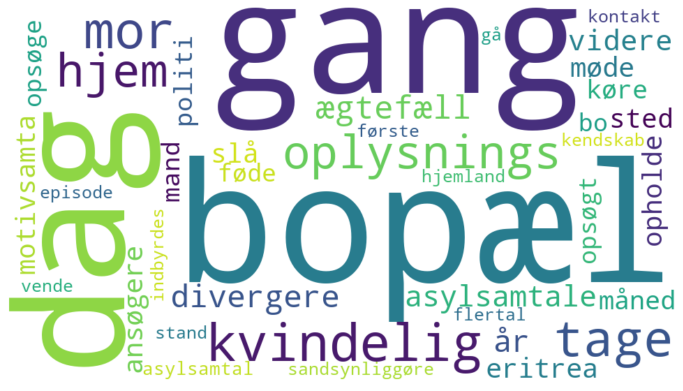

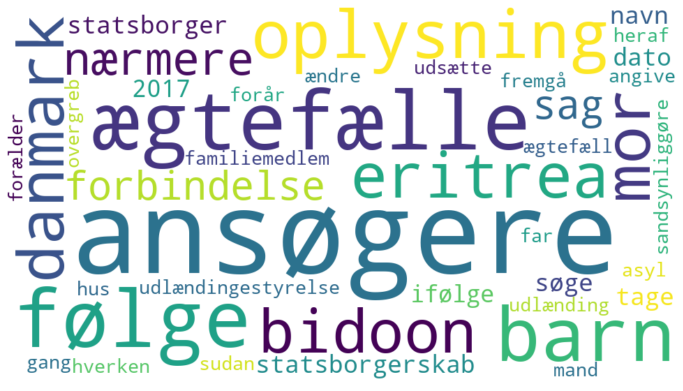

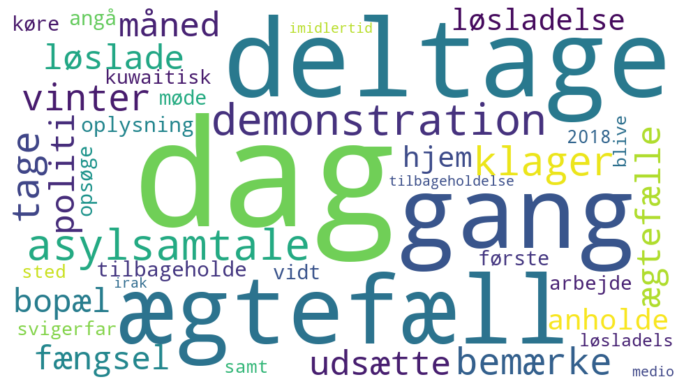

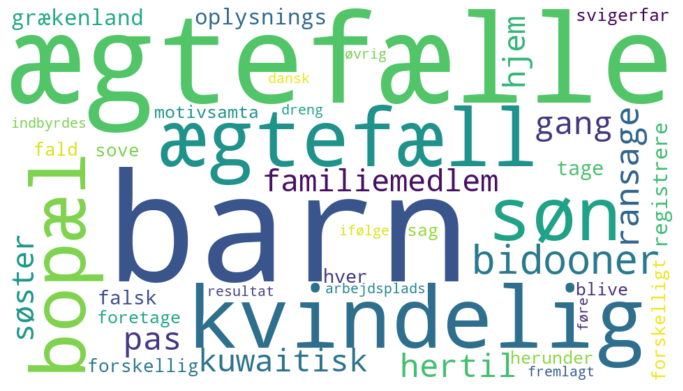

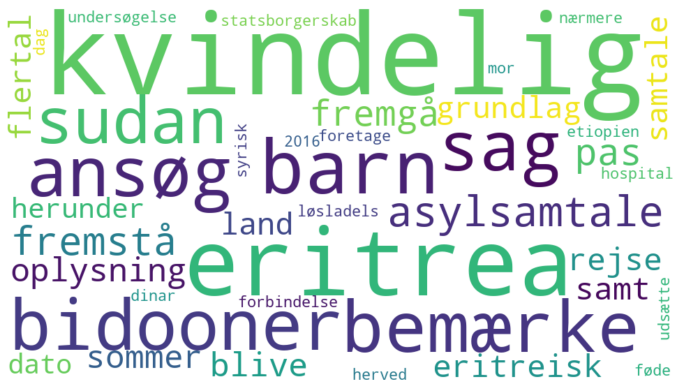

In [34]:
wordcloud_topics(SVD_model, count_text_vectorizer.get_feature_names_out())